# Introduction to Game Theory

[Game Theory](https://en.wikipedia.org/wiki/Game_theory) is the study of mathematical strategies among rational agents in a game. It has very important applications in financial markets, fundamentally due to the fact that every trade occurs between two parties who both believe their side of the trade to be the correct one. In this way, a market forms an effective 'game' with defined rules and millions of (approximately) rational agents participating. 

Understanding game theory principles such as [adverse selection](https://en.wikipedia.org/wiki/Adverse_selection) and [nash equilibria](https://en.wikipedia.org/wiki/Nash_equilibrium) are very useful concepts when designing strategies in quant trading. Studying games such as chess and poker are also good resources for learning ideas from game theory and supplement this course well. For a good introduction to poker theory see [The Course](https://books.google.co.uk/books/about/The_Course.html?id=GJSOrgEACAAJ&redir_esc=y).

## Nash Equilibrium
In this notebook we will look at one algorithm for solving the Nash equilibrium in the trivial example of rock paper scissors. In the next notebook we will look at a more interesting dice game which is inspired by an actual quant trading interview question.

The concept of nash equilibrium essentially defines the solution to a non-cooperative game. It is a fairly nuanced idea and we recommend going through the wiki page or some textbooks before continuing. In summary, "In a Nash equilibrium, each player is assumed to know the equilibrium strategies of the other players, and no one has anything to gain by changing only one's own strategy".

The Nash equilibrium for Rock Paper Scissors is known as a [mixed strategy](https://en.wikipedia.org/wiki/Strategy_(game_theory)#Mixed_strategy), and is simply to randomly pick each option randomly with probability $p=1/3$. Our aim is to reproduce this strategy computationally using [counterfactual regret minimization](https://poker.cs.ualberta.ca/publications/NIPS07-cfr.pdf).


## Counterfactual Regret Minimization
[Counterfactual regret minimization](https://poker.cs.ualberta.ca/publications/NIPS07-cfr.pdf) is an algorithm for solving nash equilibriums and is currently the state of the art for Texas No Limit Hold'em Poker solvers.

Let $a$ be the actions available to player $i$. We define the *strategy*, $\sigma_i(a)$, to be a probability distribution over the actions, such that $\sum_{\text{actions}} \sigma_i(a) = 1$. If there are multiple turns in the game, then each turn will have a different strategy depending on the previous actions taken by other players. This defines a *strategy profile* for the player $\sigma_i$.

In the example of rock-paper-scissors both players have only one turn, and the actions are:
* Choose Rock
* Choose Paper
* Choose Scissors

Next we define the *utility*, $u_i(a)$, as the expected payoff for player $i$ for picking action $a$. Imagine that player A has a strategy where they pick rock 100% of the time. The utility for player B would look like $u_B(a) = \{ R=0, P=1, S=-1 \}$ for a $1 bet on each game.

The algorithm works iteratively, starting with a random strategy for both players and slightly adjusting the strategies each iteration to eventually converge onto the nash equilibrium strategy.

Define the immediate counterfactual *regret* on iteration $t$ of an action $a$ as $R_i^t(a)$. It is the difference between the utility of our strategy and the utility of picking action $a$ 100% of the time. 
$$
r_i^t(a) = u_i(a) - \sum_{a'} \sigma_i(a') u_i(a')
$$
This quantifies how much regret we have for not choosing action $a$ as part of our strategy. If our regret is very positive, then we would want to add more of action $a$ to our strategy; and if the regret is very negative, then we would want to stop doing action $a$ as much.

The accumulated regret is simply the sum of immediate regret over all iterations
$$
R^T_i(a) = \sum_t^T r_i^t(a)
$$
To choose our strategy on iteration $t$ we use the accumulated regret. Let $R^{T,+}_i(a) = \max(R^T_i(a),0)$ be the positive portion of accumulated regret.

We choose the strategy for each player at iteration $T$ according to
$$
\sigma^T_i(a) = 
\frac{R^{T,+}_i(a)}{\sum_{a} R^{T,+}_i(a)}.
$$
This has the nice property that the probabilities are always normalised over the actions, such that $\sum_{\text{actions}} \sigma_i(a) = 1$. We also will choose $\sigma^T_i(a) = 0$ for any action that has negative accumulated regret, as it is a very bad move.

We must also consider the edge case in which $\sum_a R^{T,+}_i(a)=0$ in which we will simply choose all strategies equally
$$
\sigma^T_i(a) = \frac{1}{A}
$$
where $A$ is the total number of actions.

This now completes the counterfactual regret minimization algorithm. There is a proof (you can find in the linked papers) that choosing strategies according to this scheme will converge to nash equilibrium as $T \rightarrow \infty$.

## Rock Paper Scissors
Let us now implement this algorithm for rock paper scissors. We perform the CFR steps iteratively for each player. The hero is the current player who is updating their regrets taking the villains (other player's) strategy as an input.


In [86]:
import numpy as np
import matplotlib.pyplot as plt

In [87]:
'''
Represent actions by their index in the strategy array. Here we will use the convention 
rock     = 0
paper    = 1
scissors = 2
'''
actions = [0, 1, 2]

def payoff(action: int, villain_strategy: np.array(float)) -> float:
    '''
    PAYOFF FUNCTION HERE
    '''
    if action == 0:
        # payoff is scissors minus paper
        EV = villain_strategy[2] - villain_strategy[1]
        
    elif action == 1:
        EV = villain_strategy[0] - villain_strategy[2]

    elif action == 2:
        EV = villain_strategy[1] - villain_strategy[0]

    return EV


In [88]:
'''
Calculate immediate regret for every action
'''

def calculate_immediate_regret(hero_strategy: np.array(float), villain_strategy: np.array(float)) -> np.array(float):
    '''
    IMMEDIATE REGRET 
    '''
    hero_EV = 0
    for a in actions:
        hero_EV += hero_strategy[a] * payoff(a, villain_strategy)

    regrets = np.zeros(3)
    
    for a in actions:
        regrets[a] = payoff(a, villain_strategy) - hero_EV

    return regrets



In [89]:
'''
Calculate new strategy based on accumulated regret for the hero
'''

def calculate_strategy(acc_regrets: np.array(float)) -> np.array(float):
    '''
    CALCULATE NEW STRATEGY
    '''
    positive_regret = np.where(acc_regrets > 0, acc_regrets, 0)

    normalisation = np.sum(positive_regret)

    if normalisation == 0:
        return np.ones(3) / 3
        
    return positive_regret / normalisation
        



In [90]:
'''
Run CFR algorithm.
We set initial strategy for player A and B to both pick rock 100% of the time. 
'''

strategyA = np.array([1.0, 0.0, 0.0])
strategyB = np.array([1.0, 0.0, 0.0])

acc_regretsA = np.array([0.0, 0.0, 0.0])
acc_regretsB = np.array([0.0, 0.0, 0.0])

steps = 100

strat_history = []

for t in range(steps):
    acc_regretsA += calculate_immediate_regret(strategyA, strategyB)
    strategyA = calculate_strategy(acc_regretsA)
    
    acc_regretsB += calculate_immediate_regret(strategyB, strategyA)
    strategyB = calculate_strategy(acc_regretsB)

    strat_history.append(strategyA)


In [91]:
strat_history = np.array(strat_history)

avg_strats = np.cumsum(strat_history, axis=0)
norm = np.sum(avg_strats, axis=1)[:,None]

strats = avg_strats / norm

Running this as-is works quite well, but if you plot the strategy over iterations you will notice there are some  oscillations around the nash equilibrium. To smooth this effect we perform another averaging step over the strategy history.
$$
\overline{\sigma}(a) = 
\frac{\sum_{t} {\sigma^t(a)}}{\sum_{t, a} {\sigma}^t(a)}.
$$
This is simply saying if our strategy for an action oscillates like $\sigma^t = \{0.4, 0.5, 0.4, 0.5, 0.4, \cdots \}$ between CFR steps, then at the end, the nash equilibrium we will take is the average $\overline{\sigma} = 0.45$. 

Implementing this and plotting the strategies calculated shows a nice convergence to the nash equilibrium.

![RPS Nash](figs/rps_converging.png)

*Rock-Paper-Scissors Nash Equilibrium Converging from CFR*

Another interesting thing to investigate is 'best response' strategies. We can change the CFR loop to only update strategies for player A, keeping B fixed as whatever we set it to, and calculating the optimal counter strategy to B. For example, the obvious 'best response' strategies to  player B choosing rock 100% of the time, is to pick paper 100%. 

However, there are some non-obvious best responses, even in rock-paper-scissors. For example what is the best response to 50% rock, 50% paper. Or 40% rock, 60% paper? Is there any difference to 30% rock, 70% paper?

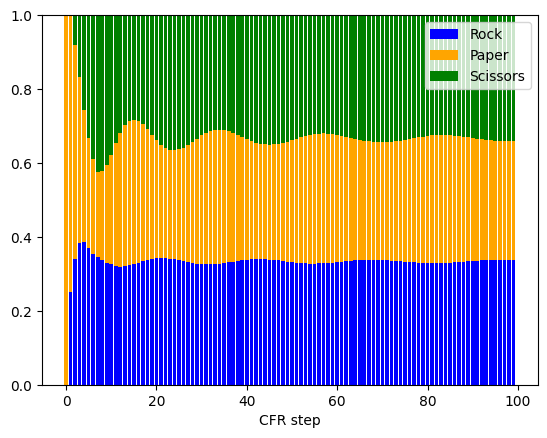

In [92]:
rock = [a[0] for a in strats]
paper = [a[1] for a in strats]
scissors = [a[2] for a in strats]

indices = np.arange(len(strats))

fig, ax = plt.subplots()
ax.bar(indices, rock, color='blue', label='Rock')
ax.bar(indices, paper, bottom=rock, color='orange', label='Paper')
ax.bar(indices, scissors, bottom=np.add(rock, paper), color='green', label='Scissors')

ax.legend()
ax.set_xlabel('CFR step')

# plt.show()
plt.savefig('figs/rps_converging.png')
